# Generating Data
Like in my post on [building neural networks from scratch](https://beckernick.github.io/neural-network-scratch/), I'm going to use simulated data. I can easily simulate separable data by sampling from a multivariate normal distribution.

In [14]:
import numpy as np
import nodepy 
import matplotlib.pyplot as plt
import sys
import scipy as sp
from scipy import io
%matplotlib inline

np.random.seed(12)
num_observations = 3
clusters = 1
dim = 10
spread = 10
margin = np.random.randint(10, size=dim) * 50

for i in range(clusters):
    if i == 0:
        x1 = np.random.multivariate_normal(np.random.randint(spread, size=dim) + margin, np.identity(dim), num_observations)
        x2 = np.random.multivariate_normal(np.random.randint(spread, size=dim), np.identity(dim), num_observations)
    else:
        x1 = np.append(x1, np.random.multivariate_normal(np.random.randint(spread, size=dim) + margin, np.identity(dim), num_observations), axis=0)
        x2 = np.append(x2, np.random.multivariate_normal(np.random.randint(spread, size=dim), np.identity(dim), num_observations), axis=0)

simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(len(x1)),
                              np.ones(len(x2))))
intercept = np.ones((simulated_separableish_features.shape[0], 1))
simulated_separableish_features = np.hstack((intercept, simulated_separableish_features))
dim += 1

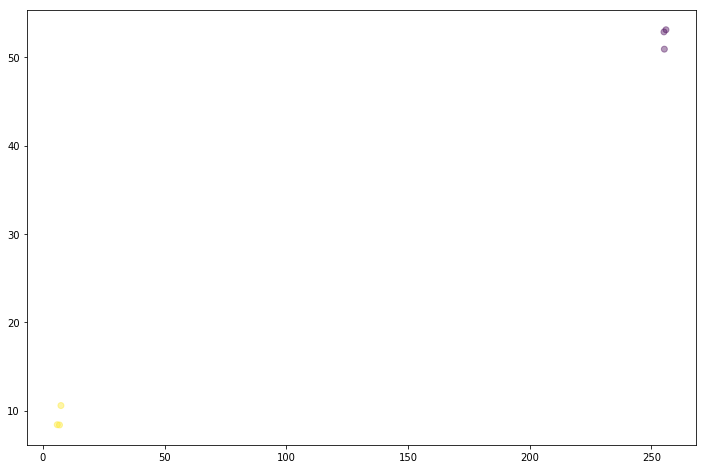

In [15]:
plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, -1], simulated_separableish_features[:, 2],
            c = simulated_labels, alpha = .4)

# Quadratic

In [16]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

In [17]:

def grad_logistic(X, Y, w):
    pred = np.dot(X, w) - Y
    return np.dot(X.T, pred)

def loss_logistic(X, Y, w):
    pred = Y - np.dot(X, w)
    return np.dot(pred.T, pred)


## Show that GD works

In [18]:
def gd(f, df, num_steps, learning_rate, inits, period=5000):
    losses = np.zeros(int(num_steps/period))
    weights = inits
    for step in xrange(num_steps):
        # Update weights with log likelihood gradient
        gradient = - df(weights)
        #gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient
        # Print log-likelihood every so often
        if step % period == 0:
            losses[int(step/period)] = f(weights)
        if step % (num_steps/5) == 0:
            print losses[int(step/period)]
        
    return weights, losses

In [19]:
weights = np.zeros(dim)
f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)
weights, losses = gd(f, df, num_steps = int(1e6), learning_rate = 1e-6, 
                     inits=weights, period=500)

2.99630761387
0.00435561620349
0.001774297702
0.000746544112458
0.000315142007554


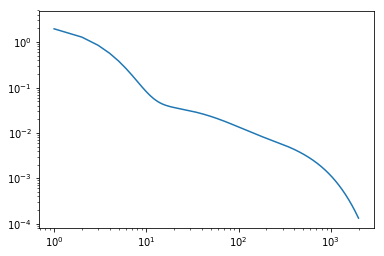

In [20]:
plt.loglog(losses[:])

In [21]:
print(losses[-1])

0.000133370115814


In [22]:
def nag(f, df, num_steps, learning_rate, inits, period=5000):
    losses = np.zeros(int(num_steps/period))
    x = inits
    x_prev = inits
    y = inits
    for k in xrange(num_steps):
        # Update weights with log likelihood gradient
        x, x_prev = y - learning_rate * df(y), x
        y = x + (k-1.0)/(k+2.0)*(x-x_prev)

        # Print log-likelihood every so often
        if k % period == 0:
            losses[int(k/period)] = f(x)
        if k % (num_steps/10) == 0:
            print losses[int(k/period)]
        
    return x, losses

In [23]:
weights = np.zeros(dim)
f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)
weights, losses = nag(f, df, num_steps = int(1e6), learning_rate = 1e-6, 
                     inits=weights, period=500)

2.99630761387
6.52038963954e-09
2.46094713069e-10
7.38007698086e-12
4.06242652325e-11
1.91336541871e-11
1.26646857911e-12
1.1655808672e-12
2.64738930811e-12
1.01590385601e-12


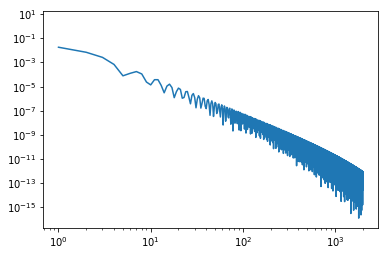

In [24]:
plt.loglog(losses[:])

# Simulate ODE flow

In [25]:

import nodepy.runge_kutta_method as rk
import nodepy.convergence as cv
from nodepy import ivp

class ODE_IVP(nodepy.ivp.IVP):
    
    def __init__(self, X, Y, p, u0, t0=0., T=1000000., desc='', name=''):
        
        #intercept = np.ones((X.shape[0], 1))
        #self.X = np.hstack((intercept, X))
        self.Y = Y
        self.X = X
        self.p = float(p)
        self.u0  = u0
        self.dim = len(u0)/2
        self.rhs = self.dynamics
        self.T   = T
        self.exact = None
        self.description = desc
        self.t0 = t0
        self.name = name
    
    def dynamics(self, t, u):
        x = u[:self.dim]
        v = u[self.dim:]
        p = self.p
        dv = - (p+1) / (t) * v - p**2 * t**(p-2) * grad_logistic(self.X, self.Y, x)
        return np.append(v, dv)
    
    

In [26]:
# Same integrator on different ODE

def simulate(p, s, N, period, step, inits):
    h = step
    if s==1:
        name = 'FE'
    elif s==2:
        name = 'SSP22'
    elif s==4:
        name = 'RK44'
    elif s==8:
        name = 'PD8'
    else:
        return None
    u = [inits]
    integrator =rk.loadRKM(name)
    loop = N/period
    losses = np.zeros(int(N/period))
    ode_ivp = ODE_IVP(simulated_separableish_features, simulated_labels, p, u0=u[-1])
    for j in range(loop):
        losses[j] = loss_logistic(simulated_separableish_features, simulated_labels, u[-1][:dim])
        t,u = integrator(ode_ivp, t0= 0.1 + j * period * h, dt=h, max_steps=period)
        ode_ivp = ODE_IVP(simulated_separableish_features, simulated_labels, p, u0=u[-1])
    return losses



In [35]:
N = int(1e2)
truncate = 0
period = 100
pvalues = [1,2,4]
nrange = period * np.arange(int(N/period)) - period + 1

/usr/local/lib/python2.7/site-packages/matplotlib/ticker.py:2041: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


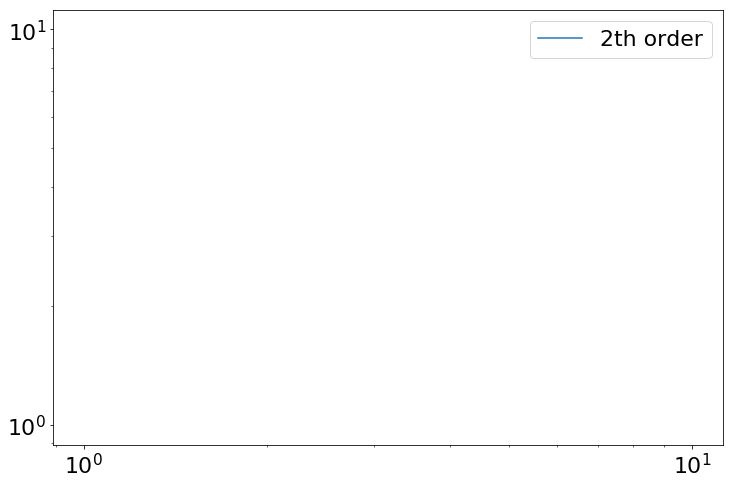

In [36]:
plt.figure(figsize = (12, 8))
losses = simulate(4, 2, N, period, 1e-4, np.zeros(dim * 2))
plt.loglog(nrange, losses[truncate:], label=str(2) + 'th order')
plt.legend()
plt.rcParams.update({'font.size': 32})


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python2.7/site-packages/nodepy/runge_kutta_method.py:1444: RuntimeWarning: invalid value encountered in multiply
  y[i] += self.alpha[i,j]*y[j] + dt*self.beta[i,j]*fy[j]
/usr/local/lib/python2.7/site-packages/numpy/ma/core.py:6592: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in subtract


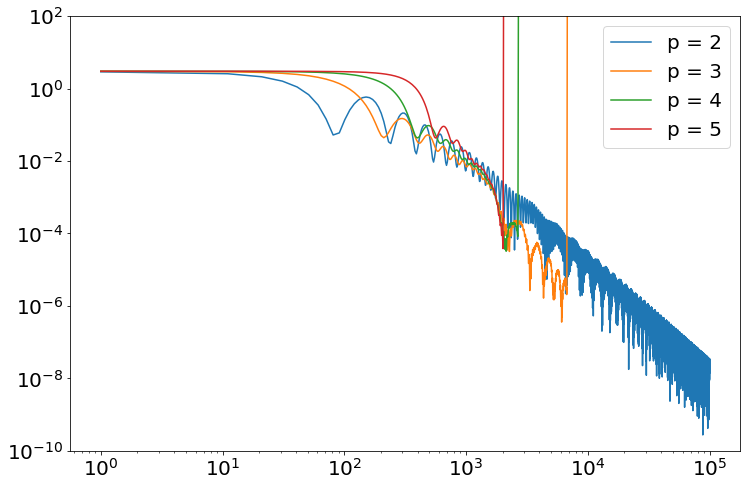

In [28]:
# Different choice of p
N = int(1e5)
truncate = 0
period = 10
pvalues = [2, 3, 4, 5]
nrange = period * np.arange(int(N/period))- period + 1

svals = [4, 4, 4, 4]
steps = [5e-4, 5e-4, 5e-4, 5e-4]
plt.figure(figsize = (12, 8))

weights = np.zeros(dim)
f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)

losslst = np.zeros((len(svals), len(nrange)))
for i, s in enumerate(svals):
    losses = simulate(pvalues[i], s, N, period, steps[i], np.zeros(dim * 2))
    losslst[i,:] = losses
    plt.loglog(nrange, losses[truncate:], label='p = ' + str(pvalues[i]))
plt.legend()
plt.ylim(1e-10, 100)
plt.rcParams.update({'font.size': 20})


In [29]:
sp.io.savemat('choose-q.mat', {'loss_matrix': losslst})

2.99630761387
1.78782897527e-06
3.22657056933e-10
5.82312922674e-14
1.05094152397e-17
2.99630761387
5.5963949487e-15
8.70495150618e-15
4.36433698705e-16
6.18504902029e-18
4.60300596238e-19
3.49219324004e-19
3.40788838001e-20
1.29321888844e-22
2.24885030906e-23


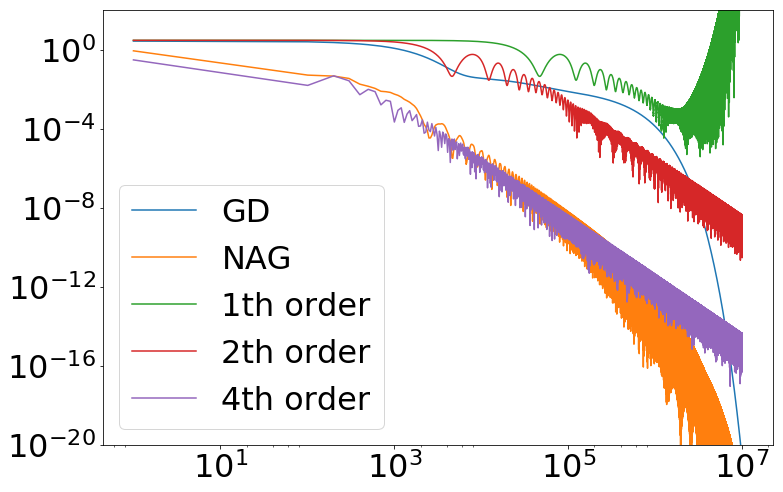

In [32]:
N = int(1e7)
truncate = 0
period = 100
pvalues = [1,2,4]
nrange = period * np.arange(int(N/period))- period + 1

svals = [1,2,4]
steps = [1e-6, 1e-5, 1e-3]
plt.figure(figsize = (12, 8))
loss_matrix = np.zeros((len(svals)+2, len(nrange)))


weights = np.zeros(dim)
f = lambda x: loss_logistic(simulated_separableish_features, simulated_labels, x)
df = lambda x: grad_logistic(simulated_separableish_features, simulated_labels, x)

_, gdlosses = gd(f, df, num_steps = N, learning_rate = 1e-6, 
                     inits=weights, period=period)
loss_matrix[0] = gdlosses

weights = np.zeros(dim)
plt.loglog(nrange, gdlosses[truncate:], label='GD')
_, naglosses = nag(f, df, num_steps = N, learning_rate = 1e-6, 
                     inits=weights, period=period)
loss_matrix[1] = naglosses

plt.loglog(nrange, naglosses[truncate:], label='NAG')

for i, s in enumerate(svals):
    losses = simulate(2, s, N, period, steps[i], np.zeros(dim * 2))
    loss_matrix[i+2, :] = losses
    plt.loglog(nrange, losses[truncate:], label=str(s) + 'th order')
plt.legend()
plt.ylim(1e-20, 100)
plt.rcParams.update({'font.size': 32})

In [33]:
sp.io.savemat('quaratic.mat', {'loss_matrix': loss_matrix})